<a href="https://colab.research.google.com/github/bbcndoro/bigData/blob/kris/PysparkDatasetBesar_praktikum2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[✓] KAGGLE_USERNAME dan KAGGLE_KEY sudah di-set di environment.
[*] Downloading dataset 'fronkongames/steam-games-dataset' to './kaggle_data' ...
Dataset URL: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset
[✓] Download completed.
[*] Found zip file: ./kaggle_data/steam-games-dataset.zip
[*] Extracting zip file...
[✓] Extraction completed.
[✓] SparkSession created.
[*] Loading data from: ./kaggle_data/games.csv
[*] Data loaded.
root
 |-- AppID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Release date: string (nullable = true)
 |-- Estimated owners: string (nullable = true)
 |-- Peak CCU: integer (nullable = true)
 |-- Required age: integer (nullable = true)
 |-- Price: double (nullable = true)
 |-- DiscountDLC count: integer (nullable = true)
 |-- About the game: integer (nullable = true)
 |-- Supported languages: string (nullable = true)
 |-- Full audio languages: string (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Header image:

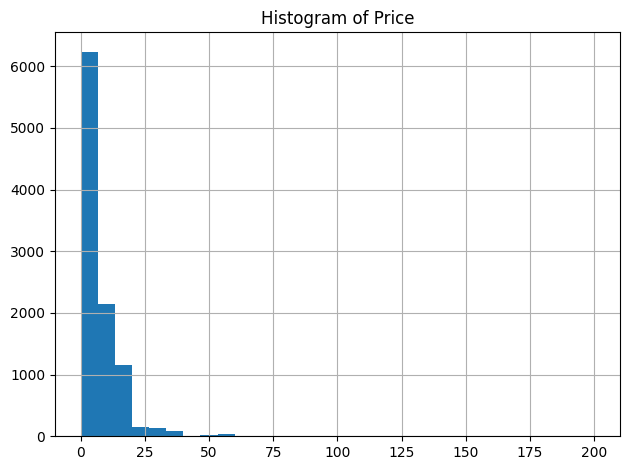

[+] Aggregating top categories...


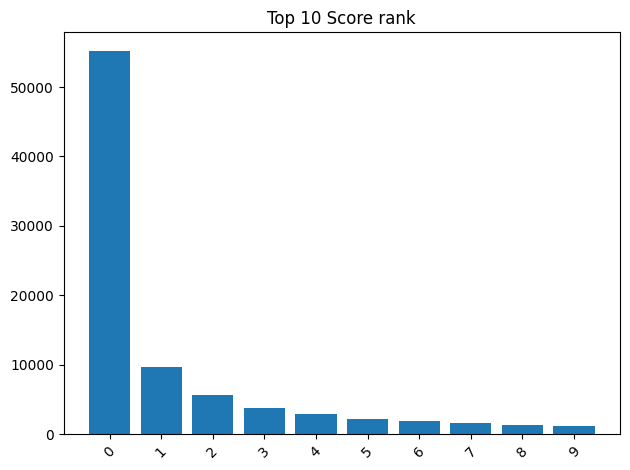

[*] Spark stopped. Selesai.


In [ ]:
# pyspark_kaggle_nojson.py

import os
import zipfile

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, avg, max as spark_max, min as spark_min

# ============================
# 1. KONFIGURASI PENGGUNA
# ============================

KAGGLE_USERNAME = "masyadi"
KAGGLE_KEY      = "KGAT_23c2e9a32f90ad34beaffaf8eb5c25f1"

KAGGLE_DATASET = "fronkongames/steam-games-dataset"
LOCAL_DATA_DIR = "./kaggle_data"
DATA_FILE_NAME = "games.csv" # Corrected file name

NUMERIC_COL  = "Price"
CATEGORY_COL = "Score rank"

# ============================
# 2. HELPER: SET ENV KAGGLE
# ============================

def setup_kaggle_env(username: str, key: str):
    if not username or "ISI_" in username or not key or "ISI_" in key:
        raise ValueError(
            "KAGGLE_USERNAME dan KAGGLE_KEY belum diisi.\n"
            "Silakan buka file ini dan ganti KAGGLE_USERNAME dan KAGGLE_KEY."
        )

    os.environ["KAGGLE_USERNAME"] = username
    os.environ["KAGGLE_KEY"] = key
    print("[✓] KAGGLE_USERNAME dan KAGGLE_KEY sudah di-set di environment.")

# ============================
# 3. DOWNLOAD DATASET KAGGLE
# ============================

def download_from_kaggle(dataset_name: str, download_path: str):
    try:
        from kaggle.api.kaggle_api_extended import KaggleApi
    except ImportError:
        raise ImportError("Install dulu: pip install kaggle")

    os.makedirs(download_path, exist_ok=True)

    api = KaggleApi()
    api.authenticate()

    print(f"[*] Downloading dataset '{dataset_name}' to '{download_path}' ...")
    api.dataset_download_files(dataset_name, path=download_path, unzip=False)
    print("[✓] Download completed.")

    zip_files = [f for f in os.listdir(download_path) if f.endswith(".zip")]
    if not zip_files:
        raise FileNotFoundError(
            "Zip file hasil download tidak ditemukan.\n"
            f"Cek nama dataset: {dataset_name}"
        )

    zip_path = os.path.join(download_path, zip_files[0])
    print(f"[*] Found zip file: {zip_path}")

    print("[*] Extracting zip file...")
    with zipfile.ZipFile(zip_path, "r") as z:
        z.extractall(download_path)
    print("[✓] Extraction completed.")

    return download_path

    print("\n=== Isi Folder Kaggle Data ===")
    print(os.listdir("./kaggle_data"))


# ============================
# 4. INISIALISASI SPARK
# ============================

def create_spark(app_name: str = "KaggleBigDataAnalysis"):
    spark = (
        SparkSession.builder
        .appName(app_name)
        .getOrCreate()
    )
    print("[✓] SparkSession created.")
    return spark

# ============================
# 5. LOAD DATASET DENGAN SPARK
# ============================

def load_big_csv_with_spark(spark, data_dir: str, file_name: str):
    csv_path = os.path.join(data_dir, file_name)

    if not os.path.exists(csv_path):
        raise FileNotFoundError(
            f"File CSV '{csv_path}' tidak ditemukan.\n"
            "Cek kembali DATA_FILE_NAME."
        )

    print(f"[*] Loading data from: {csv_path}")

    df = (
        spark.read
            .option("header", "true")
            .option("inferSchema", "true")
            .csv(csv_path)
    )

    print("[*] Data loaded.")
    df.printSchema()

    row_count = df.count()
    print("[*] Row count:", row_count)

    return df

# ============================
# 6. ANALISIS SEDERHANA (EDA)
# ============================

def basic_eda(df, numeric_col: str, category_col: str):
    print("\n=== BASIC INFO ===")
    print("Jumlah baris:", df.count())
    print("Jumlah kolom:", len(df.columns))
    print("Nama kolom:", df.columns)

    if numeric_col not in df.columns:
        raise ValueError(f"Kolom '{numeric_col}' tidak ditemukan.")
    if category_col not in df.columns:
        raise ValueError(f"Kolom '{category_col}' tidak ditemukan.")

    print(f"\n=== DESCRIPTIVE STATS: {numeric_col} ===")
    df.select(numeric_col).describe().show()

    print(f"\n=== AGGREGATIONS for '{numeric_col}' ===")
    agg_df = df.select(
        spark_max(col(numeric_col)).alias("max_value"),
        spark_min(col(numeric_col)).alias("min_value"),
        avg(col(numeric_col)).alias("avg_value")
    )
    agg_df.show()

    print(f"\n=== TOP 10 CATEGORY COUNTS: {category_col} ===")
    df.groupBy(category_col).agg(count("*").alias("cnt")).orderBy(col("cnt").desc()).show(10, truncate=False)

    return agg_df

# ============================
# 7. VISUALISASI (MELALUI PANDAS)
# ============================

def visualize_with_matplotlib(df, numeric_col: str, category_col: str, sample_size: int = 10000):
    import matplotlib.pyplot as plt

    print(f"[+] Sampling {sample_size} rows...")
    numeric_sample = df.select(numeric_col).dropna().limit(sample_size).toPandas()

    plt.figure()
    numeric_sample[numeric_col].hist(bins=30)
    plt.title(f"Histogram of {numeric_col}")
    plt.tight_layout()
    plt.show()

    print("[+] Aggregating top categories...")
    top_cat_df = (
        df.groupBy(category_col)
            .agg(count("*").alias("cnt"))
            .orderBy(col("cnt").desc())
            .limit(10)
            .toPandas()
    )

    plt.figure()
    plt.bar(top_cat_df[category_col].astype(str), top_cat_df["cnt"])
    plt.xticks(rotation=45)
    plt.title(f"Top 10 {category_col}")
    plt.tight_layout()
    plt.show()

# ============================
# 8. MAIN
# ============================

if __name__ == "__main__":
    setup_kaggle_env(KAGGLE_USERNAME, KAGGLE_KEY)
    data_dir = download_from_kaggle(KAGGLE_DATASET, LOCAL_DATA_DIR)
    spark = create_spark()

    df = load_big_csv_with_spark(spark, data_dir, DATA_FILE_NAME)

    basic_eda(df, NUMERIC_COL, CATEGORY_COL)
    visualize_with_matplotlib(df, NUMERIC_COL, CATEGORY_COL)

    spark.stop()
    print("[*] Spark stopped. Selesai.")